In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

# GYM SET

In [218]:
df_gym = pd.read_csv("megaGymDataset.csv")
df_gym

,Unnamed: 0,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,NaN
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,8.1,Average
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,Strength,Triceps,E-Z Curl Bar,Beginner,8.1,Average
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN


In [226]:
df_gym["Equipment"].unique()

array(['Bands', 'Barbell', 'Kettlebells', 'Dumbbell', 'Other', 'Cable',
       'Machine', 'Body Only', 'Medicine Ball', 'None', 'Exercise Ball',
       'Foam Roll', 'E-Z Curl Bar'], dtype=object)

In [15]:
#split dataset in features and target variable
feature_cols = [ "Title",	"BodyPart", "Equipment", "Level",	"Rating",	"RatingDesc" ]
X = df_gym[feature_cols] # Features
y = df_gym["Type"] # Target variable

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [17]:
X_train

,Title,BodyPart,Equipment,Level,Rating,RatingDesc
653,Alternating Exercise Ball Knee Tucks - Gethin ...,Abdominals,Exercise Ball,Intermediate,NaN,NaN
1895,Goblet squat-,Quadriceps,Kettlebells,Intermediate,NaN,NaN
708,Close-grip EZ-bar curl,Biceps,Barbell,Beginner,8.9,Average
1305,Romanian Deadlift,Hamstrings,Barbell,Intermediate,8.1,Average
23,Kettlebell 3-point leg extension,Abdominals,Kettlebells,Intermediate,0.0,NaN
...,...,...,...,...,...,...
2763,Side Wrist Pull,Shoulders,None,Beginner,8.4,Average
905,Knee Circles,Calves,Body Only,Beginner,6.3,Average
1096,30 Chest Shoulder-Height Cable Fly,Chest,Cable,Intermediate,NaN,NaN
235,Hanging leg raise with throw down,Abdominals,Body Only,Beginner,0.0,NaN


In [18]:
# # Create Decision Tree classifer object
# clf_gym = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf_gym = clf_gym.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf_gym.predict(X_test)

In [19]:
X_test

,Title,BodyPart,Equipment,Level,Rating,RatingDesc
473,Holman Feet-Elevated Up-Down Elbow Plank,Abdominals,Body Only,Intermediate,NaN,NaN
2101,UP Quad Extension,Quadriceps,Machine,Intermediate,NaN,NaN
1703,Inverted Row with Straps,Middle Back,Other,Beginner,6.4,Average
303,Frog kick,Abdominals,Body Only,Intermediate,NaN,NaN
664,FYR2 Standing Banded Leg Abduction,Abductors,Bands,Intermediate,NaN,NaN
...,...,...,...,...,...,...
242,Suspended Crunch,Abdominals,Body Only,Beginner,0.0,Average
2727,Upward Stretch,Shoulders,Body Only,Intermediate,6.7,Average
370,HM Inchworm,Abdominals,Body Only,Intermediate,NaN,NaN
2571,FYR Dumbbell front raise to lateral raise,Shoulders,Dumbbell,Intermediate,NaN,NaN


In [20]:
y_pred

array(['0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0',
       '1', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1',
       '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1',
       '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0',
       '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0',
       '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1',
       '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1

In [21]:

# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(df_gym['Type'].nunique())

cats = [ "Type",  "Equipment", "Level", "RatingDesc" ]

df_gym_cat = df_gym

for cat in cats:
  codes, uniques = pd.factorize( df_gym_cat[cat] )
  df_gym_cat[cat] = codes
df_gym_cat['Rating'] = df_gym_cat['Rating'].fillna(0)

codes, uniques = pd.factorize( df_gym['Type'] )
# for i in codes:
#   print(i)

7


In [22]:
df_gym_cat

,Unnamed: 0,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,0,Abdominals,0,0,0.0,-1
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,0,Abdominals,0,0,0.0,-1
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,0,Abdominals,0,0,0.0,-1
3,3,Banded crunch,The banded crunch is an exercise targeting the...,0,Abdominals,0,0,0.0,-1
4,4,Crunch,The crunch is a popular core exercise targetin...,0,Abdominals,0,0,0.0,-1
...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,0,Triceps,12,0,8.1,0
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,0,Triceps,12,1,8.1,0
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,0,Triceps,12,0,0.0,-1
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,0,Triceps,12,0,0.0,-1


In [23]:
df_gym_cat["BodyPart"].unique()

array(['Abdominals', 'Adductors', 'Abductors', 'Biceps', 'Calves',
       'Chest', 'Forearms', 'Glutes', 'Hamstrings', 'Lats', 'Lower Back',
       'Middle Back', 'Traps', 'Neck', 'Quadriceps', 'Shoulders',
       'Triceps'], dtype=object)

In [24]:
# df_gym[df_gym["Type"] == "Cardio"]

# df_gym.groupby('BodyPart').count()
feature_cols = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ]

parts = df_gym_cat['BodyPart'].unique()

models = []
partial_dfs = []

for part in parts:
  temp_df = df_gym_cat[df_gym["BodyPart"] == part]
  temp_df.insert(0, 'New_ID', range(1, 1 + len(temp_df)))

  codes, uniques = pd.factorize( temp_df['Type'] )
  temp_df['Type'] = codes


  # print(temp_df['Type'].astype('category').cat.categories , "\n")

  X = temp_df[feature_cols] # Features
  y = temp_df["New_ID"] # Target variable

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
  print(X_train)

    # Create Decision Tree classifer object
  clf_gym = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf_gym = clf_gym.fit(X_train,y_train)

  #Predict the response for test dataset
  y_pred = clf_gym.predict(X_test)

  

  lst = [[0,	0,	0,	0.0,	-1]]
  df_test = pd.DataFrame(lst, columns = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ])
  df_test
    
  y_sing = clf_gym.predict(df_test)
  print("Result: ", y_sing[0], " ")

  # df.loc[df['column_name'] == some_value]

  print(type( temp_df.loc[temp_df['New_ID'] == y_sing[0]] ))

  print("RES_NAME: ", temp_df.loc[temp_df['New_ID'] == y_sing[0]]['Title'] )
  models.append(clf_gym)
  partial_dfs.append(temp_df)

     Type  Equipment  Level  Rating  RatingDesc
440     0          7      0     0.0          -1
587     0          7      0     0.0          -1
472     0          7      0     0.0          -1
378     0          7      0     0.0          -1
483     0          7      0     0.0          -1
..    ...        ...    ...     ...         ...
144     0          4      0     0.0          -1
645     0          5      0     0.0          -1
72      0          3      0     0.0          -1
235     0          7      1     0.0          -1
37      0          2      0     0.0          -1

[463 rows x 5 columns]
Result:  2  
<class 'pandas.core.frame.DataFrame'>
RES_NAME:  1    Banded crunch isometric hold
Name: Title, dtype: object
     Type  Equipment  Level  Rating  RatingDesc
669     0          6      0     9.0           0
666     1         11      1     4.0           0
697     0          7      0     0.0          -1
662     0          0      1     8.6           0
699     1          9      1     3.6  

<ipython-input-24-3b200c3e5c07>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-24-3b200c3e5c07>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-24-3b200c3e5c07>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Result:  8  
<class 'pandas.core.frame.DataFrame'>
RES_NAME:  875    Smith machine standing calf raise
Name: Title, dtype: object
      Type  Equipment  Level  Rating  RatingDesc
1099     2          8      0     5.9           0
1117     0          3      1     8.3           0
1025     0          7      0     0.0          -1
974      0          7      1     7.8           0
1047     0          7      0     0.0          -1
...    ...        ...    ...     ...         ...
1118     0          3      0     8.2           0
1170     0          4      0     0.0          -1
987      0          7      1     0.0          -1
1150     0          3      0     0.0          -1
952      0          1      0     0.0          -1

[183 rows x 5 columns]
Result:  6  
<class 'pandas.core.frame.DataFrame'>
RES_NAME:  920    HM Banded Cross-Over Pull
Name: Title, dtype: object
      Type  Equipment  Level  Rating  RatingDesc
1194     0          3      0     0.0          -1
1191     0          3      1     5.3  

<ipython-input-24-3b200c3e5c07>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-24-3b200c3e5c07>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-24-3b200c3e5c07>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [25]:
print(models)

[DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier()]


#USER CODE

In [26]:
import enum

In [27]:

calories1 = pd.read_excel("cal_table.xls")
calories3 = pd.read_excel("excel.xlsx")


In [28]:
calories1.rename(columns={'Наименование': 'Продукт', 
                          'Белков': 'Белки, г', 
                          'Жиров': 'Жиры, г',
                          'Углеводов': 'Углеводы, г', 
                          'Калорийность': 'Калорийность, Ккал'}, inplace=True)
# calories1

In [29]:
# calories3

In [30]:
calories = pd.concat([calories1, calories3])
calories.reset_index(drop=True)

,Продукт,"Белки, г","Жиры, г","Углеводы, г","Калорийность, Ккал"
0,Абрикосы,1.0,0.0,10.0,45
1,Авокадо,2.0,19.0,7.0,197
2,Аджика,2.0,3.0,8.0,59
3,Айва,1.0,0.0,9.0,41
4,Айсберг,1.0,0.0,2.0,17
...,...,...,...,...,...
1387,Яичница глазунья,7.6,18.8,3.1,213
1388,Яичный порошок,12.9,20.9,0.9,243
1389,Яйцо отварное,46.0,37.3,4.5,542
1390,Яйцо под майонезом,12.7,11.5,0.7,157


In [221]:
gym_activities = pd.read_excel("gym_activities.xlsx") # calories burnt per 30 minutes
gym_activities

,Gym Activities,125-pound person,155-pound person,185-pound person
0,Weight Lifting: general,90,108,126
1,Aerobics: water,120,144,168
2,"Stretching, Hatha Yoga",120,144,168
3,Calisthenics: moderate,135,162,189
4,Aerobics: low impact,165,198,231
...,...,...,...,...
92,Playing w/kids: moderate effort,114,141,168
93,"Heavy Cleaning: wash car, windows",135,162,189
94,"Paint, paper, remodel: inside",142,176,210
95,Moving: household furniture,170,211,252


In [341]:
import difflib as difflib
import random

def get_calories(food):
  foods = difflib.get_close_matches(food, calories["Продукт"], n=10, cutoff=0.45)
  # print(foods)
  if foods:
    food_cal = calories[calories["Продукт"] == foods[0]]
    # print(food_cal)
    print(food_cal.values.tolist())
    return food_cal.values.tolist()[0][-1]
  print(f"Food {food} not found!")
  return None

def recommend_exercise(calories_proficit, weight, gym_activities):
  # calories are per 30 minutes
  print(f"You are {calories_proficit} kcal overlimit")
  suggestions = gym_activities[gym_activities["155-pound person"] <= calories_proficit]
  # print(suggestions)
  suggestions = suggestions.sample(len(suggestions) // 3 ).sort_values(by=['155-pound person'], ascending=False)
  # print(suggestions)
  recommendation = "The following activites can be suggested:\n"
  for item in suggestions.iterrows():
    # print("HERE: ", item[1].tolist())

    cal_coef = item[1][1] + (item[1][2] - item[1][1]) / (155-125) * abs(155 - weight*2.205)
    # print(f"{item[1][1]}, {item[1][2]}, {weight*2.205}")

    recommendation += f'{item[1][0]} for { int( calories_proficit / ( cal_coef  / 30 ) ) } minutes\n'
  print(recommendation)


def get_exercise(ex, body_part):
  # print(df_gym_cat[df_gym_cat["BodyPart"] == body_part]["Title"])
  exes = difflib.get_close_matches(ex, df_gym_cat[df_gym_cat["BodyPart"] == body_part]["Title"], n=10, cutoff=0.3)
  # print(exes)
  if exes:
    # print("Exes: ", exes)
    # chosen = random.choice(exes)
    # exercise = df_gym_cat[df_gym_cat["Title"] == chosen]
    exercises = [ df_gym_cat[df_gym_cat['Title'] == x] for x in exes ]
    # print(exercise)
    # print(exercise.values.tolist())
    return exercises
  print(f"Exercises close to {ex} not found!")
  return None
  
a = get_exercise("Bench", "Chest")
# print(a)

recommend_exercise(150, 70, gym_activities)

# enter foods
# calc summ of calories
# suggest exercise or what else to eat?


You are 150 kcal overlimit
The following activites can be suggested:
Golf: using cart for 42 minutes
Volleyball: non-competitive, general play for 49 minutes
Water Volleyball for 49 minutes
Food Shopping: with cart for 52 minutes
Frisbee for 52 minutes
Cooking for 78 minutes
Sleeping for 236 minutes



In [220]:
import datetime

class Training_Program():
  history = []

class Gender(enum.Enum):
  male = "male"
  female = "female"

class User:
  def __init__(self, name, age, height, weight, gender, ex_type=0, equip=0, level=0):
    self.name = name
    self.age = age
    self.height = height
    self.weight = weight
    self.gender = Gender(gender)
    self.BMI = self.calculate_BMI()

# add calories depending on age
    self.calories_intake = 3000 if self.gender == Gender.male else 2400 
    self.calories_today = 0
    

    self.ex_type = ex_type
    self.equip = equip
    self.level = level

    self.program = None

    self.history = None

  def __str__ (self):
    s = f"""Name: {self.name},
    Age: {self.age},
    Height: {self.height},
    Weight: {self.weight},
    Gender: {self.gender},
    Calories daily: {self.calories_intake},
    Calories today: {self.calories_today},
    BMI: {self.BMI}\n"""

    if self.program:
      s += self.show_program()
    
    return s



# if BMI <= 18.4:
#     print("You are underweight.")
# elif BMI <= 24.9:
#     print("You are healthy.")
# elif BMI <= 29.9:
#     print("You are over weight.")
# elif BMI <= 34.9:
#     print("You are severely over weight.")
# elif BMI <= 39.9:
#     print("You are obese.")
# else:
#     print("You are severely obese.")

  def calculate_BMI(self):
    return self.weight / (self.height/100)**2

  def generate_program(self):
    exercises = {}
    for i in range(len(models)):
      body_part = parts[i]
      model = models[i]
      table = partial_dfs[i]

      lst = [[self.ex_type,	self.equip,	self.level,	0.0,	-1]]
      df_test = pd.DataFrame(lst, columns = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ])
      # print(df_test)

      exercise = model.predict(df_test)
      id = table.index[table['New_ID'] == exercise[0]][0]
      # print("ID: ", id, ", RES_NAME: ", table.loc[table['New_ID'] == exercise[0]]['Title'] )
      # print("ID: ", id, ", RES_NAME: ", df_gym.iloc[[id]]['Title'].tolist()[0] )
      exercises[body_part] = df_gym.iloc[[id]]
    # for i in exercises.keys():
    #   print(f"For bodypart {i}, recommend { exercises.get(i)['Title'].tolist()[0]}")

    print("TEST: ", exercises["Adductors"] )

    self.program = exercises

    # columns = [x['Title'].tolist()[0] for x in self.program.values()]
    columns = []
    for x in self.program.values():
      y = x['Title'].tolist()[0]
      columns.append(f"{y}, reps")
      columns.append(f"{y}, weight (kg)")
      columns.append(f"{y}, rest (s)")


    # print("TEST: ", columns)

    self.history = pd.DataFrame(columns=columns)
    self.history.insert(0, "Training_number", None)
    self.history.insert(0, "Date", None)

  def show_program(self):
    s = ""
    for i in self.program.keys():
      s += f"For bodypart {i}, recommend { self.program.get(i)['Title'].tolist()[0]}\n"
    return s



  def calories_calculation(self, foods):
    # cals = 0
    for food in foods:
      self.calories_today += get_calories(food)

    print(f"Total {self.calories_today} eaten today")
    if self.calories_today > self.calories_intake:
      print(f"You are over limit on daily calories, recommend an exercise")
      recommend_exercise(self.calories_today - self.calories_intake, self.weight, gym_activities)
      
    elif self.calories_today < self.calories_intake:
      print(f"Some foods you can eat today:")
      food_vars = calories[calories["Калорийность, Ккал"] <= (self.calories_intake - cals)]
      print(food_vars.sort_values(by=['Калорийность, Ккал'], ascending=False).head())

  def calc_heartrate(self, model, exercises):
    dist = float(ex["dis"]) / 1000
    speed = (float(ex["dis"]) / 1000) / (float(ex["run_time"]) / 3600)
    calories = float(ex["calorie"])
    time = float(ex["run_time"])
    heart_rate_real = float(ex["avg_heart_rate"])
    print(f"Dist: {dist}, speed: {speed}, cal: {calories}")
    print(f"Actual H/R: {heart_rate_real}")

    # total_running_time	total_calories	distance	avg_speed
    heart_rate_calculated = model.predict([time, calories, dist, speed])
    print(f"Calculated H/R: {heart_rate_calculated}")

    if heart_rate_calculated - heart_rate_real > 5:
      print("Your heart rate is low")
    elif heart_rate_real - heart_rate_calculated > 5:
      print("Your heartrate is high!")
    else:
      print("Your heartrate is normal")


test_person = User("Name", 25, 179, 100, "female", ex_type=1)
print(test_person)
test_person.generate_program()

food_list = ["Яблоко", "Пирог", "Пельмени", "Пельмени", "Пельмени", "Пельмени", "Пельмени", "Сыр", "Шоколадка", "Конфеты шоколадные", "Курица", "Протеиновый коктейль", "Утка"]

test_person.calories_calculation(food_list)

Name: Name,
    Age: 25,
    Height: 179,
    Weight: 100,
    Gender: Gender.female,
    Calories daily: 2400,
    Calories today: 0,
    BMI: 31.210012171904747

TEST:       Unnamed: 0               Title  \
681         681  Carioca quick step   

                                                  Desc         Type  \
681  The carioca quick step is a lateral bodyweight...  Plyometrics   

      BodyPart  Equipment         Level  Rating RatingDesc  
681  Adductors  Body Only  Intermediate     0.0        NaN  
[['Яблоки', 1.0, 1.0, 13.0, 60]]
[['Поросята', 26.4, 4.5, 0.2, 147]]
[['Пельмени жареные', 18.1, 11.1, 7.0, 177]]
[['Пельмени жареные', 18.1, 11.1, 7.0, 177]]
[['Пельмени жареные', 18.1, 11.1, 7.0, 177]]
[['Пельмени жареные', 18.1, 11.1, 7.0, 177]]
[['Пельмени жареные', 18.1, 11.1, 7.0, 177]]
[['Сыр 45%', 26.0, 26.0, 0.0, 336]]
[['Шоколад сладкий', 4.5, 35.4, 52.5, 549]]
[['Конфеты шоколадные', 4.0, 26.3, 59.2, 491]]
[['Курица', 21.0, 11.0, 1.0, 186]]
[['Апельсиновый сок', 0.0, 0.

In [120]:
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Side Neck Stretch, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"


In [121]:
# For bodypart Abdominals, recommend Banded crunch isometric hold
# For bodypart Adductors, recommend Side-To-Side Adductor Stretch
# For bodypart Abductors, recommend Lateral Band Walk
# For bodypart Biceps, recommend Incline dumbbell biceps curl
# For bodypart Calves, recommend Smith machine standing calf raise
# For bodypart Chest, recommend HM Banded Cross-Over Pull
# For bodypart Forearms, recommend Standing alternating band speed row
# For bodypart Glutes, recommend UNS Banded Glute Bridge
# For bodypart Hamstrings, recommend 30 Legs Sumo Deadlift
# For bodypart Lats, recommend UN Band Assisted Pull-up Neutral
# For bodypart Lower Back, recommend Band good morning-
# For bodypart Middle Back, recommend Partner side plank band row
# For bodypart Traps, recommend Band seated row
# For bodypart Neck, recommend Lying Face Down Plate Neck Resistance
# For bodypart Quadriceps, recommend Boss Everline Resistance-Band Pull Sprint
# For bodypart Shoulders, recommend HM Lateral Raise
# For bodypart Triceps, recommend Band overhead triceps press

In [122]:
def add_training_results_dummy(user, exercise, weight, reps, rest, t_num, date=datetime.datetime(2023, 5, 17)):
  # print([x['Title'].tolist()[0] for x in user.program.values()])
  if not exercise in [x['Title'].tolist()[0] for x in user.program.values()]:
    print("Wrong exercise!")
    return

  # print(user.history.index[user.history['Training_number'] == t_num].tolist())
  # if t_num in user.history["Training_number"]:
  #   print("Yes")
  # else:
  #   # print("no")
  #   # df.loc[len(df)] 
  ind = len( user.history )
  if user.history.index[user.history['Training_number'] == t_num].tolist():
    ind = user.history.index[user.history['Training_number'] == t_num].tolist()[0]

  # user.history.loc[ ind ] = {"Date": date, "Training_number": t_num, f"{exercise}, reps": reps,
  #                                         f"{exercise}, weight (kg)": weight,
  #                                         f"{exercise}, rest (s)": rest}
  user.history.loc[ ind, ["Date"] ] = date
  user.history.loc[ ind, "Training_number" ] = int(t_num)
  user.history.loc[ ind, f"{exercise}, reps"]  = float(reps)
  user.history.loc[ ind, f"{exercise}, weight (kg)" ] = weight
  user.history.loc[ ind, f"{exercise}, rest (s)" ] = rest

  if len(user.history) > 10:
    pass

    # update weights
  # user.history

test_exec = [x['Title'].tolist()[0] for x in test_person.program.values()][0]
test_exec_1 = [x['Title'].tolist()[0] for x in test_person.program.values()][1]
test_exec_2 = [x['Title'].tolist()[0] for x in test_person.program.values()][2]

add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2, date=datetime.datetime(2020, 5, 18))
add_training_results_dummy(test_person, test_exec_1, 10, 26, 42, 2, date=datetime.datetime(2020, 5, 18))

add_training_results_dummy(test_person, test_exec_2, 10, 26, 42, 3, date=datetime.datetime(2020, 5, 19))
add_training_results_dummy(test_person, test_exec_1, 10, 26, 42, 3, date=datetime.datetime(2020, 5, 19))
add_training_results_dummy(test_person, test_exec, 10, 26, 42, 3, date=datetime.datetime(2020, 5, 19))
# add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2)
# add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2)
# add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2)
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Side Neck Stretch, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
test_person.history["Training_number"]

0    2
1    3
Name: Training_number, dtype: object

In [124]:
def add_training_results(user, exercise, weight, reps, rest, t_num, date=datetime.datetime(2023, 5, 17)):
  # print([x['Title'].tolist()[0] for x in user.program.values()])
  # print(exercise)
  if not exercise in [x['Title'].tolist()[0] for x in user.program.values()]:
    print("Wrong exercise!")
    return

  # print(user.history.index[user.history['Training_number'] == t_num].tolist())
  # if t_num in user.history["Training_number"]:
  #   print("Yes")
  # else:
  #   # print("no")
  #   # df.loc[len(df)] 
  ind = len( user.history )
  if user.history.index[user.history['Training_number'] == t_num].tolist():
    ind = user.history.index[user.history['Training_number'] == t_num].tolist()[0]

  # user.history.loc[ ind ] = {"Training_number": t_num, f"{exercise}, reps": reps,
  #                                         f"{exercise}, weight (kg)": weight,
  #                                         f"{exercise}, rest (s)": rest}

  
  user.history.loc[ [ind], ["Date"] ] = date
  user.history.loc[ [ind], ["Training_number"] ] = t_num
  user.history.loc[ [ind], [f"{exercise}, reps"] ] = reps
  user.history.loc[ [ind], [f"{exercise}, weight (kg)"] ] = weight
  user.history.loc[ [ind], [f"{exercise}, rest (s)"] ] = rest

  if len(user.history) > 10:
    w, b = get_recommended_weights(test_person.history, exercise)
    # recom = my_output([weight], w, b)[0]
    predict = get_predicted_weight(test_person.history, my_output, w, b, weight, reps)

    # update weights
  # user.history

add_training_results(test_person, "Banded crunch isometric hold", 10, 26, 42, 2, date=datetime.datetime(2023, 5, 18))
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Side Neck Stretch, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2023-05-18 00:00:00,2,26,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
add_training_results(test_person, "Lazy", 10, 26, 42, 2)
test_person.history

Wrong exercise!


,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Side Neck Stretch, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2023-05-18 00:00:00,2,26,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
# import random

# # filling history with dummy data
# for i in range(10):
#   add_training_results(test_person, "Banded crunch isometric hold", 
#                        round(random.uniform(7, 15), 0), 
#                        round(random.uniform(10, 20), 0), 
#                        round(random.uniform(30, 45), 0),
#                        i)
  
# test_person.history

In [127]:
test_person.program

{'Abdominals':    Unnamed: 0                         Title  \
 1           1  Banded crunch isometric hold   
 
                                                 Desc  Type    BodyPart  \
 1  The banded crunch isometric hold is an exercis...     0  Abdominals   
 
    Equipment  Level  Rating  RatingDesc  
 1          0      0     0.0          -1  ,
 'Adductors':      Unnamed: 0               Title  \
 681         681  Carioca quick step   
 
                                                   Desc  Type   BodyPart  \
 681  The carioca quick step is a lateral bodyweight...     1  Adductors   
 
      Equipment  Level  Rating  RatingDesc  
 681          7      0     0.0          -1  ,
 'Abductors':      Unnamed: 0                      Title Desc  Type   BodyPart  Equipment  \
 679         679  IT Band and Glute Stretch  NaN     3  Abductors          7   
 
      Level  Rating  RatingDesc  
 679      0     2.4           0  ,
 'Biceps':      Unnamed: 0                         Title  \
 700 

Добавить - возмодность менять упражнения


In [128]:
import numpy as np

def change_exercise(user: User, body_part: str, new_exercise: str, gym_set):
  # print()
  # part = gym_set[gym_set["Title"] == old_exercise]["BodyPart"].tolist()[0]
  print(f"Bodypart: {body_part}")
  
  if body_part in list(df_gym_cat["BodyPart"].unique()) :
    ex = get_exercise(new_exercise, body_part=body_part)
    # print("HERE: ", ex)
    print(f"Found following exercises:")
    for i in range(len(ex)):
      print(f"Number {i + 1}) - {list(ex[i]['Title'])[0] }")
    print("Enter the number of the exercise to choose:")
    choice = -1
    print(len(ex))
    while choice < 0 or choice > len(ex):
      try:
        choice = int(input()) - 1
      except:
        print("Please enter a valid number")
    title = list(ex[choice]['Title'])[0]
    print(f"Chose exercise {title}")
    
    user.program[body_part] = ex[choice]

    user.history[f"{title}, reps"] = np.nan
    user.history[f"{title}, weight (kg)"] = np.nan
    user.history[f"{title}, rest (s)"] = np.nan
  else:
    print(f"Bodypart {body_part} not found")

print("Before:")
print(test_person)
change_exercise(test_person, "Abdominals", "Chest", df_gym_cat)
print("\n\nAfter:")
print(test_person)

Before:
Name: Name,
    Age: 25,
    Height: 179,
    Weight: 100,
    Gender: Gender.female,
    Calories daily: 2400,
    Calories today: 3103,
    BMI: 31.210012171904747
For bodypart Abdominals, recommend Banded crunch isometric hold
For bodypart Adductors, recommend Carioca quick step
For bodypart Abductors, recommend IT Band and Glute Stretch
For bodypart Biceps, recommend Incline dumbbell biceps curl
For bodypart Calves, recommend Agility Ladder
For bodypart Chest, recommend Bench Press With Short Bands
For bodypart Forearms, recommend Standing alternating band speed row
For bodypart Glutes, recommend UNS Banded Glute Bridge
For bodypart Hamstrings, recommend 30 Legs Sumo Deadlift
For bodypart Lats, recommend One Handed Hang
For bodypart Lower Back, recommend Band good morning-
For bodypart Middle Back, recommend Partner side plank band row
For bodypart Traps, recommend Snatch Shrug
For bodypart Neck, recommend Side Neck Stretch
For bodypart Quadriceps, recommend Speed Box Squat

In [129]:
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)","Crunches, reps","Crunches, weight (kg)","Crunches, rest (s)"
0,2023-05-18 00:00:00,2,26,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
change_exercise(test_person, "1", "2", df_gym_cat)

Bodypart: 1
Bodypart 1 not found


In [131]:
print(parts)

['Abdominals' 'Adductors' 'Abductors' 'Biceps' 'Calves' 'Chest' 'Forearms'
 'Glutes' 'Hamstrings' 'Lats' 'Lower Back' 'Middle Back' 'Traps' 'Neck'
 'Quadriceps' 'Shoulders' 'Triceps']


СДЕЛАТЬ:
  
  Подсчет килокалорий
  
  Временные советы (отдых)

  Прогресс упражнений

  Выбор упражнений

  Подсчет калорий от еды

    Советовать упражнения в зависимости от съеденных калорий и времени суток

  Найти приложения для похудения С ОТКРЫТЫМ API

  Найти базы данных с калориями



СДЕЛАТЬ UI

Посмотреть возможности Android

Дополнительно: Если связать с картами, то сделать push нотификации "Вы рядом с площадкой"


Теория:

Эмуляция сервиса, получаю количество килокалорий



# Map Search

In [233]:
test_long = 37.44338754155181
test_lat = 55.83872304132719

In [234]:
import json
import requests
from IPython.display import Image

ya_api = "be69a8a0-9ea0-42cf-ad7a-5b73199a308d"

# print(f'https://search-maps.yandex.ru/v1/?text=деревня Толстик&type=geo&lang=ru_RU&apikey={ya_api}')
req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={test_long},{test_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=5&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"
print(req_str)

x = requests.get(req_str)

print(x.text)

https://search-maps.yandex.ru/v1/?text=Спортивная площадка&ll=37.44338754155181,55.83872304132719&spn=0.552069,0.550552&type=biz&results=5&lang=ru_RU&apikey=be69a8a0-9ea0-42cf-ad7a-5b73199a308d
{"type":"FeatureCollection","properties":{"ResponseMetaData":{"SearchResponse":{"found":52,"display":"multiple","boundedBy":[[37.34433727,55.687094],[37.62009573,55.96219207]]},"SearchRequest":{"request":"Спортивная площадка","skip":0,"results":5,"boundedBy":[[37.16735304,55.56246844],[37.71942204,56.1130205]]}}},"features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[37.561989,55.790569]},"properties":{"name":"Спортивная площадка","description":"Ленинградский просп., 33, стр. 14, Москва, Россия","boundedBy":[[37.547647,55.786354],[37.566656,55.797625]],"CompanyMetaData":{"id":"96579331426","name":"Спортивная площадка","address":"Москва, Ленинградский проспект, 33, стр. 14","Categories":[{"class":"playground","name":"Спортплощадка"}],"Hours":{"text":"ежедневно, круглосуточно","Av

In [235]:


# print(json.dumps(x.json()["features"][0]["geometry"]["coordinates"], indent=2))

# x.json()["features"]
def get_all_coordinates(x):
  gym_coordinates = []
  for item in x.json()["features"]:
    # print(item["geometry"]["coordinates"])
    gym_coordinates.append(item["geometry"]["coordinates"])
  return gym_coordinates

gym_coordinates = get_all_coordinates(x)

## Getting the map

In [236]:
# 37.620070,55.753630,pmwtm12~37.64,55.76363,pmwtm99

def points_create(l):
  points = []
  
  for item in l:
    points.append(f"{item[0]},{item[1]},pm2wtm{l.index(item) + 1}")
  return "~".join(points)
# print(gym_coordinates)
# points_create(gym_coordinates)

In [237]:


# map = requests.get("https://static-maps.yandex.ru/1.x/?ll=37.620070,55.753630&size=450,450&z=13&l=map&pt=37.620070,55.753630,pmwtm12~37.64,55.76363,pmwtm99")
# display(Image(map.content))

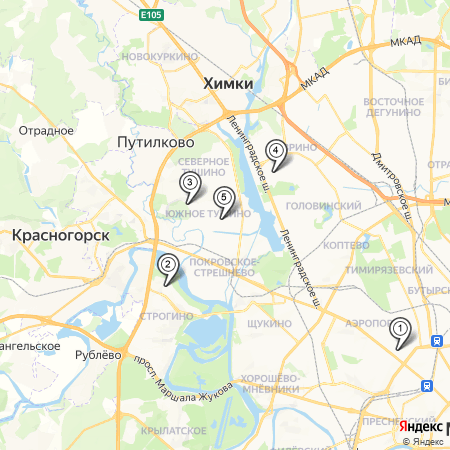

In [238]:

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={test_long},{test_lat}&size=450,450&z=11&l=map&pt={points_create(gym_coordinates)}""")
display(Image(map.content))

In [239]:
# https://static-maps.yandex.ru/1.x/?l=map&pl=37.656577,55.741176,37.656748,55.741419,37.655131,55.741814,37.658257,55.742524,37.659811,55.743066,37.659667,55.743233,37.659551,55.743603,37.659775,55.743928,37.662398,55.745281


## How to get location (Lat and long)

In [330]:

ip_stack_key = "e51b2f79be62ac3ac1f0932cefcd4123"

send_url = f"http://api.ipstack.com/check?access_key={ip_stack_key}"
geo_req = requests.get(send_url)
geo_json = json.loads(geo_req.text)
latitude = geo_json['latitude']
longitude = geo_json['longitude']
city = geo_json['city']
geo_json

{'ip': '34.125.172.74',
 'type': 'ipv4',
 'continent_code': 'NA',
 'continent_name': 'North America',
 'country_code': 'US',
 'country_name': 'United States',
 'region_code': 'NV',
 'region_name': 'Nevada',
 'city': 'Enterprise',
 'zip': '89146',
 'latitude': 36.142398834228516,
 'longitude': -115.224853515625,
 'location': {'geoname_id': 5503766,
  'capital': 'Washington D.C.',
  'languages': [{'code': 'en', 'name': 'English', 'native': 'English'}],
  'country_flag': 'https://assets.ipstack.com/flags/us.svg',
  'country_flag_emoji': '🇺🇸',
  'country_flag_emoji_unicode': 'U+1F1FA U+1F1F8',
  'calling_code': '1',
  'is_eu': False}}

Градусы в минуты и секунды

In [331]:
import math

def get_min_sec(rad):
  ans = []
  r = math.floor(rad)
  # print(r)
  ans.append(r)
  m = (rad - math.floor(rad)) * 60
  print(m)
  ans.append(round(m, 4))
  s = round((m - math.floor(m)) * 60, 2)
  print(s)
  ans.append((round(s, 4)))
  return ans

print(test_lat)
get_min_sec(test_lat) 

55.83872304132719
50.32338247963153
19.4


[55, 50.3234, 19.4]

In [332]:
req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={test_long},{test_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=70&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"
print(req_str)

y = requests.get(req_str)

print(y.text)

https://search-maps.yandex.ru/v1/?text=Спортивная площадка&ll=37.44338754155181,55.83872304132719&spn=0.552069,0.550552&type=biz&results=70&lang=ru_RU&apikey=be69a8a0-9ea0-42cf-ad7a-5b73199a308d
{"type":"FeatureCollection","properties":{"ResponseMetaData":{"SearchResponse":{"found":138,"display":"multiple","boundedBy":[[37.16762908,55.56274564],[37.71914601,56.1127472]]},"SearchRequest":{"request":"Спортивная площадка","skip":0,"results":70,"boundedBy":[[37.16735304,55.56246844],[37.71942204,56.1130205]]}}},"features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[37.561989,55.790569]},"properties":{"name":"Спортивная площадка","description":"Ленинградский просп., 33, стр. 14, Москва, Россия","boundedBy":[[37.547647,55.786354],[37.566656,55.797625]],"CompanyMetaData":{"id":"96579331426","name":"Спортивная площадка","address":"Москва, Ленинградский проспект, 33, стр. 14","Categories":[{"class":"playground","name":"Спортплощадка"}],"Hours":{"text":"ежедневно, круглосуточно"

In [333]:
import random

lat_start = random.uniform(-0.09, 0.09)
long_start = random.uniform(-0.09, 0.09)
lat_end = random.uniform(-0.09, 0.09)
long_end = random.uniform(-0.09, 0.09)

# Random float number
print(lat_start)


-0.042795641412428934


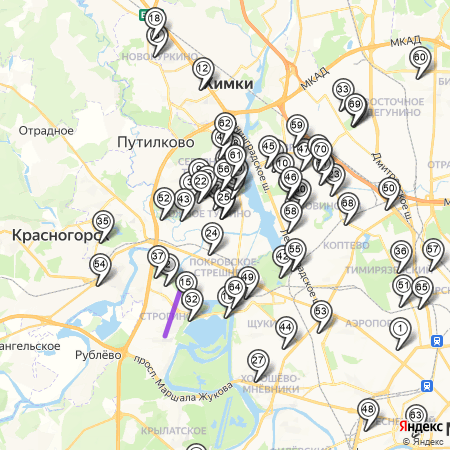

In [334]:


points = get_all_coordinates(y)

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={test_long},{test_lat}&size=450,450&z=11&l=map&pt={points_create(points)}"""\
                   f"&pl={test_long + long_start},{test_lat + lat_start},{test_long + long_end},{test_lat + lat_end}")
display(Image(map.content))


In [335]:
def coord_distance(x1, y1, x2, y2):
  # print(f"{x1}, {y1}, {x2}, {y2}")
  return math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def notification_gym_nearby(point, distance):
  print(f"Notification sent, point {point}. distance {distance}")

In [336]:
# print(test_lat)
# print(test_lat + lat_start)
# print(test_lat + lat_end)


# steps = 100
# for i in range(steps):
#   cur_lat = test_lat + lat_start + (lat_end - lat_start) * i / steps
#   cur_long = test_long + long_start + (long_end - long_start) * i / steps
#   print(f"{cur_long}, {cur_lat}")

In [337]:
steps = 100
dist = 0.01

flag_point = 0

for i in range(steps):
  cur_lat = test_lat + lat_start + (lat_end - lat_start) * i / steps
  cur_long = test_long + long_start + (long_end - long_start) * i / steps
  # print(f"{cur_long}, {cur_lat}")
  
  closest = 0
  min_dist = 100
  for j in points:
    d = coord_distance(cur_long, cur_lat, j[0], j[1]) 
    # print(min_dist)
    if d < dist:
      if d < min_dist:
        min_dist = d
        # flag += 1
        closest = points.index(j) + 1
        
        if closest != flag_point:
          notification_gym_nearby(closest, min_dist)
          flag_point = closest


  if closest:
    print(f"Closest point is {closest}, in {d} meters!")
  else:
    print("No closest point...")




No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
No closest point...
Notification sent, point 15. distance 0.00994975892320544
Closest point is 15, in 0.11562711438572339 meters!
Closest point is 15, in 0.11539470431627041 meters!
Closest point is 15, in 0.1151624540802571 meters!
Closest point is 15, in 0.11493036464665683 meters!
Closest point is 15, in 0.11469843699161833 meters!
Closest point is 15, in 0.11446667209848937

# Google fit

In [ ]:

UID = "XYZ"
OAUTH_TOKEN="ya29.a0AWY7CkkjpHw0S8fKe-mXDHi3yxepkH74NUUsEA7CH5VPYwPmFxNlhjSJGHq9zcgp7JVBaIlvBAK2mhfZVjwhCDQ1jDtSXDSg-d5m7NgJPdTcRktvLPd1QY0OrrV7sNSoKTVi27eONdyOfeOMlRo8pWFxrQEQaCgYKAfQSARISFQG1tDrpex2vpJKe53FNaqUMBZ0nRw0163"
APP_SECRET_KEY = "XXX"
CLIENT_ID = "AAA"

import ast
import requests
url = "https://fitness.googleapis.com/fitness/v1/users/me/sessions"

headers = { 'content-type': 'application/json',
            'Authorization': 'Bearer %s' % OAUTH_TOKEN }
r = requests.get(url, headers=headers)

print(r.status_code)
dict_str = r.content.decode("utf-8")
mydata = ast.literal_eval(dict_str)
(mydata)

# https://fitness.googleapis.com/fitness/v1/users/me/sessions
# google_fit = requests.get(f"""https://fitness.googleapis.com/fitness/v1/users/me/sessions""")
# google_fit

In [ ]:
apptoken= "RQVBQEJyQktGXip6SltGImp2ej48BAAEAAAAAIjiO3VW3QImkgtdJCi7ahfpM592a_DZz09ZaMPA1HhlfA2Hyfgr5qKetRkSKDqF6_2x4abY7bx7wATpFlQdebB0bfCXq9BGQv3JDPVF1TTTSSGxQoEITJgIf6Uxq5wKVWf95EcCrP4oEmUbQkF0aGZPmkC6dC5iHrQGWctKe8004jQjGWA5jmKz8qyMSYSYz"

# api-mifit-de2.huami.com/v1/data/band_data.json
# https://api-mifit-de2.huami.com/v1/sport/run/history.json

def get_history():
    r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/history.json', headers={
        'apptoken': apptoken
    }, params={
        'source': 'run.mifit.huami.com',
    })
    r.raise_for_status()

    return r.json()
exercise_history = get_history()
exercise_history

In [ ]:
def get_detail(track_id, source):
    r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/detail.json', headers={
        'apptoken': apptoken
    }, params={
        'trackid': track_id,
        'source': source,
    })
    r.raise_for_status()

    return r.json()

get_detail(1683886602, "run.mifit.huami.com")

In [ ]:
# apptoken=RQVBQEJyQktGXip6SltGImp2ej48BAAEAAAAAIjiO3VW3QImkgtdJCi7ahfpM592a_DZz09ZaMPA1HhlfA2Hyfgr5qKetRkSKDqF6_2x4abY7bx7wATpFlQdebB0bfCXq9BGQv3JDPVF1TTTSSGxQoEITJgIf6Uxq5wKVWf95EcCrP4oEmUbQkF0aGZPmkC6dC5iHrQGWctKe8004jQjGWA5jmKz8qyMSYSYz; _ga_HW3XDMYYCG=GS1.1.1684074577.2.1.1684076429.0.0.0


In [ ]:
ex = exercise_history["data"]["summary"][0]
print(ex["dis"])
print( (float(ex["dis"]) / 1000) / (float(ex["run_time"]) / 3600))
print(ex["total_step"])
print(ex["calorie"])
print(ex["run_time"])
print(ex["avg_heart_rate"])
# dis - distance
# calorie
# run_time - in sec
# avg_heart_rate
# total_step

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# import matplotlib.ticker as ticker

for data in ["dis", "total_step",  "calorie", "run_time", "avg_heart_rate"]:
  y = []
  for item in exercise_history["data"]["summary"]:
    # print(item[data])
    y.append(float(item[data]))
  x = [ i for i in range(len(exercise_history["data"]["summary"])) ]
  # print(y)
  plt.title(f"Information on: {data}")
  plt.xlabel(f"Training session number")
  plt.ylabel(f"{data}")

  plt.plot(x, y)

  
  plt.xticks(np.arange(min(x), max(x)+1, 1.0))  
  # plt.yticks(np.arange(min(x), max(x)+1, 0.3))  

  plt.grid()

  plt.show()

In [ ]:
running_heartrate = pd.read_csv("running_summary.csv")

In [ ]:
running_heartrate = running_heartrate[['heart_rate', 'total_running_time', 'total_calories', 'distance', 'avg_speed']].dropna()


In [ ]:
running_train_dataset = running_heartrate.sample(frac=0.8, random_state=0)
running_test_dataset = running_heartrate.drop(running_train_dataset.index)

In [ ]:
running_train_dataset

In [ ]:
running_test_dataset

In [ ]:
running_train_features = running_train_dataset.copy()
running_test_features = running_test_dataset.copy()

running_train_labels = running_train_features.pop('heart_rate')
running_test_labels = running_test_features.pop('heart_rate')

In [ ]:
running_train_dataset.describe().transpose()


In [ ]:

import seaborn as sns

In [ ]:
# sns.pairplot(running_train_dataset[['heart_rate', 'total_running_time', 'total_calories', 
#                                     'distance', 'avg_speed']], diag_kind='kde')

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(running_train_features))
print(normalizer.mean.numpy())

first = np.array(running_train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


In [314]:
%%time
history = dnn_model.fit(
    running_train_features,
    running_train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

# def plot_loss(history):
#   plt.plot(history.history['loss'], label='loss')
#   plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error [MPG]')
#   plt.legend()
#   plt.grid(True)

# plot_loss(history)

CPU times: user 25.5 s, sys: 950 ms, total: 26.5 s
Wall time: 26 s


In [315]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(running_test_features, running_test_labels, verbose=0)
print(test_results)

{'dnn_model': 9.544912338256836}


In [316]:
running_test_features

,total_running_time,total_calories,distance,avg_speed
0,436.0,78.0,1.61317,13.563011
7,572.0,29.0,2.08591,13.428711
21,2554.0,36.0,9.85039,13.428711
24,2977.0,35.0,11.44576,13.428711
25,3116.0,36.0,11.97024,13.428711
...,...,...,...,...
5606,903.0,82.0,3.22179,12.604560
5608,1813.0,103.0,6.43941,12.604560
5609,458.0,80.0,1.61227,13.452729
5614,469.0,93.0,1.61616,12.813799


35/35 [==============================] - 0s 2ms/step


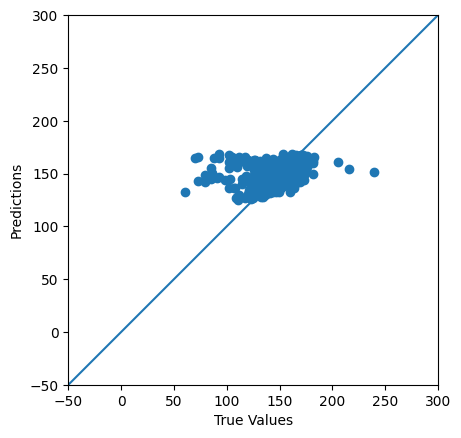

In [317]:
running_test_predictions = dnn_model.predict(running_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(running_test_labels, running_test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 300]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [318]:
running_test_predictions

array([154.55219, 156.46191, 155.09206, ..., 153.38925, 150.20776,
       146.85733], dtype=float32)

In [319]:
dnn_model.predict([436.0,	78.0,	1.61317,	13.563011])[0][0]

1/1 [==============================] - 0s 86ms/step


154.55215

In [320]:
test_person.calc_heartrate(dnn_model, ex)

Dist: 1.033, speed: 2.061419068736142, cal: 80.0
Actual H/R: 92.0
1/1 [==============================] - 0s 43ms/step
Calculated H/R: [[227.80438]]
Your heart rate is low


In [321]:
test_ex = list(test_person.program["Abdominals"]["Title"])[0]
test_ex

'Banded crunch isometric hold'

In [322]:
import random

# filling history with dummy data
for i in range(100):
  a = round(random.uniform(3, 25), 0)
  b = round(random.uniform(2, 50), 0)
  add_training_results_dummy(test_person, test_ex, 
                       a + (i // 8), 
                       b + (i // 8), 
                       round(random.uniform(30, 45), 0),
                       i,
                       datetime.datetime(2023, 5, 18) + datetime.timedelta(days= (i // 3) )
)
  
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Side Neck Stretch, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2023-05-18 00:00:00,0,28.0,11.0,33.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-18 00:00:00,1,16.0,22.0,43.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-05-18 00:00:00,2,10.0,18.0,43.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-05-19 00:00:00,3,15.0,17.0,45.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-05-19 00:00:00,4,49.0,20.0,32.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-06-18 00:00:00,95,14.0,32.0,32.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2023-06-19 00:00:00,96,57.0,22.0,32.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2023-06-19 00:00:00,97,36.0,27.0,34.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2023-06-19 00:00:00,98,40.0,33.0,43.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [323]:
print(test_person.history.index)


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')


In [324]:
def my_output(X, weights, biases):
    return tf.add(tf.multiply(X, weights), biases)

def loss_func(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))



def get_recommended_weights(tr_history, ex_name):
  x_vals =  tr_history[f"{ex_name}, reps"].astype(np.float32).to_numpy()
  print(type(x_vals))
  y_vals = tr_history[f"{ex_name}, weight (kg)"].astype(np.float32).to_numpy()
  # plt.scatter(x_vals, y_vals)
  norm = np.linalg.norm(x_vals)     # To find the norm of the array
  # print(norm)                        # Printing the value of the norm
  normalized_array = x_vals/norm  # Formula used to perform array normalization
  # print(normalized_array)


  my_opt = tf.optimizers.SGD(learning_rate=0.02)
  tf.random.set_seed(1)
  np.random.seed(0)
  weights = tf.Variable(tf.random.normal(shape=[1])) 
  # print(weights)
  biases = tf.Variable(tf.random.normal(shape=[1])) 
  history = list()

  for i in range(len(x_vals)): 
    rand_index = np.random.choice(len(x_vals))
    rand_x = [normalized_array[rand_index]] 
    rand_y = [y_vals[rand_index]]
    with tf.GradientTape() as tape:
        predictions = my_output(rand_x, weights, biases)
        loss = loss_func(rand_y, predictions)
    # print(loss)
    history.append(loss.numpy())
    gradients = tape.gradient(loss, [weights, biases])
    my_opt.apply_gradients(zip(gradients, [weights, biases]))
    # if (i + 1) % 25 == 0: 
    #     print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
    #     print(f'Loss = {loss.numpy()}') 
  # plt.plot(history)
  # plt.xlabel('iterations')
  # plt.ylabel('loss')
  # plt.show()
  return weights, biases


In [325]:


# def update_weights(tr_history, ex_name, weight, reps):
#   # x_vals =  tr_history[f"{ex_name}, повторений"].astype(np.float32).to_numpy()
#   # print(type(x_vals))
#   # y_vals = tr_history[f"{ex_name}, вес (кг)"].astype(np.float32).to_numpy()
#   # # plt.scatter(x_vals, y_vals)
#   # norm = np.linalg.norm(x_vals)     # To find the norm of the array
#   # # print(norm)                        # Printing the value of the norm
#   # normalized_array = x_vals/norm  # Formula used to perform array normalization
#   # print(normalized_array)


#   my_opt = tf.optimizers.SGD(learning_rate=0.02)
#   tf.random.set_seed(1)
#   np.random.seed(0)
#   weights = tf.Variable(tf.random.normal(shape=[1])) 
#   # print(weights)
#   biases = tf.Variable(tf.random.normal(shape=[1])) 
#   history = list()

#   for i in range(len(x_vals)): 
#     rand_index = np.random.choice(len(x_vals))
#     rand_x = [normalized_array[rand_index]] 
#     rand_y = [y_vals[rand_index]]
#     with tf.GradientTape() as tape:
#         predictions = my_output(rand_x, weights, biases)
#         loss = loss_func(rand_y, predictions)
#     # print(loss)
#     history.append(loss.numpy())
#     gradients = tape.gradient(loss, [weights, biases])
#     my_opt.apply_gradients(zip(gradients, [weights, biases]))
#     if (i + 1) % 25 == 0: 
#         print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
#         print(f'Loss = {loss.numpy()}') 
#   plt.plot(history)
#   plt.xlabel('iterations')
#   plt.ylabel('loss')
#   plt.show()
#   return weights, biases

In [326]:

w, b = get_recommended_weights(test_person.history, test_ex)
print(my_output([30.0], w, b))

<class 'numpy.ndarray'>
tf.Tensor([49.62618], shape=(1,), dtype=float32)


In [327]:
print(my_output([20.0], w, b))

tf.Tensor([40.282803], shape=(1,), dtype=float32)


In [328]:
test_person.history["Date"].unique()

array([datetime.datetime(2023, 5, 18, 0, 0),
       datetime.datetime(2023, 5, 19, 0, 0),
       datetime.datetime(2023, 5, 20, 0, 0),
       datetime.datetime(2023, 5, 21, 0, 0),
       datetime.datetime(2023, 5, 22, 0, 0),
       datetime.datetime(2023, 5, 23, 0, 0),
       datetime.datetime(2023, 5, 24, 0, 0),
       datetime.datetime(2023, 5, 25, 0, 0),
       datetime.datetime(2023, 5, 26, 0, 0),
       datetime.datetime(2023, 5, 27, 0, 0),
       datetime.datetime(2023, 5, 28, 0, 0),
       datetime.datetime(2023, 5, 29, 0, 0),
       datetime.datetime(2023, 5, 30, 0, 0),
       datetime.datetime(2023, 5, 31, 0, 0),
       datetime.datetime(2023, 6, 1, 0, 0),
       datetime.datetime(2023, 6, 2, 0, 0),
       datetime.datetime(2023, 6, 3, 0, 0),
       datetime.datetime(2023, 6, 4, 0, 0),
       datetime.datetime(2023, 6, 5, 0, 0),
       datetime.datetime(2023, 6, 6, 0, 0),
       datetime.datetime(2023, 6, 7, 0, 0),
       datetime.datetime(2023, 6, 8, 0, 0),
       datetime.da

In [329]:
# test_person.history[f"Date"].astype(int)

TypeError: ignored

In [ ]:
import seaborn as sns

def plot_reps(history, exercise):
  # df = df.astype({"a": int, "b": complex})
  history = history.astype({"Training_number": int, f"{exercise}, reps": float, f"{exercise}, weight (kg)": float})
  
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, reps" ,data=history, fit_reg=True) 
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, weight (kg)" ,data=history, fit_reg=True) 

  df_temp = history[["Date", f"{exercise}, reps", f"{exercise}, weight (kg)"]].copy()
  df_temp["dates"] = pd.to_datetime(history['Date']).apply(lambda date: date.toordinal())
  # print(df_temp["dates"])
  ax = sns.regplot(
    data=df_temp,
    x="dates",
    y=f"{exercise}, reps",
  )
  # Tighten up the axes for prettiness
  ax.set_xlim(df_temp['dates'].min() - 1, df_temp['dates'].max() + 1)
  ax.set_ylim(0, df_temp[f"{exercise}, reps"].max() + 1)
  # Replace the ordinal X-axis labels with nice, readable dates
  ax.set_xlabel('Date')
  new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
  ax.set_xticklabels(new_labels)
  ax.tick_params(axis='x', rotation=90)


def plot_weights(history, exercise):
  # df = df.astype({"a": int, "b": complex})
  history = history.astype({"Training_number": int, f"{exercise}, reps": float, f"{exercise}, weight (kg)": float})
  
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, weight (kg)" ,data=history, fit_reg=True) 

  df_temp = history[["Date", f"{exercise}, reps", f"{exercise}, weight (kg)"]].copy()
  df_temp["dates"] = pd.to_datetime(history['Date']).apply(lambda date: date.toordinal())
  # print(df_temp["dates"])
  ax = sns.regplot(
    data=df_temp,
    x="dates",
    y=f"{exercise}, reps",
  )
  # Tighten up the axes for prettiness
  ax.set_xlim(df_temp['dates'].min() - 1, df_temp['dates'].max() + 1)
  ax.set_ylim(0, df_temp[f"{exercise}, weight (kg)"].max() + 1)
  # Replace the ordinal X-axis labels with nice, readable dates
  ax.set_xlabel('Date')
  new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
  ax.set_xticklabels(new_labels)
  ax.tick_params(axis='x', rotation=90)


plot_weight_vs_reps(test_person.history, test_ex)
plot_weight_vs_reps(test_person.history, test_ex)

In [ ]:
def get_predicted_weight(history, model, w, b, weights, reps):
  # print(history)
  pred_w = round(float(model(float(reps), w, b)), 2)
  print(pred_w)
  if pred_w > weights:
    print("Good weights, recommend increasing reps")
  else:
    print("Recommend increasing weights")

get_predicted_weight(test_person.history, my_output, w, b, 7, 10)

In [ ]:

# filling history with dummy data
for i in range(101, 200):
  a = round(random.uniform(3, 25), 0)
  b = round(random.uniform(2, 50), 0)
  add_training_results(test_person, test_ex, 
                       a + (i // 8), 
                       b + (i // 8), 
                       round(random.uniform(30, 45), 0),
                       int(i // 3))
  
test_person.history

In [ ]:

w, b = get_recommended_weights(test_person.history, test_ex)
print(my_output([30.0], w, b))